In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [113]:
pd.options.mode.chained_assignment = None

df = pd.read_csv("rawdata.csv", skipinitialspace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24949 entries, 0 to 24948
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DiaChi            24949 non-null  object 
 1   TinhTrangBDS      24924 non-null  object 
 2   DienTich          24917 non-null  object 
 3   Gia/m2            24916 non-null  object 
 4   Phongngu          24926 non-null  object 
 5   TenPhanKhu        7035 non-null   object 
 6   SoTang            6726 non-null   float64
 7   PhongTam          24388 non-null  object 
 8   Loai              24926 non-null  object 
 9   GiayTo            18852 non-null  object 
 10  MaCanHo           3358 non-null   object 
 11  TinhTrangNoiThat  12790 non-null  object 
 12  HuongCuaChinh     9370 non-null   object 
 13  HuongBanCong      8670 non-null   object 
 14  DacDiem           5601 non-null   object 
 15  Gia               24949 non-null  object 
dtypes: float64(1), object(15)
memory usage: 

# Xử lý dữ liệu

In [114]:
#Chỉ lấy diện tích not null và có diện tích trong khoảng 20m2 đến 100m2
df = df[df.DienTich.notnull()]
df = df.reset_index()
for i in range(len(df.DienTich)):
    df.DienTich[i] = float(df.DienTich[i].split(' ')[0])
df = df[(df.DienTich >= 20) & (df.DienTich <= 100)]
df = df.reset_index()

In [115]:
#Chỉ lấy các căn hộ có dữ liệu về phòng ngủ và phòng tắm
df = df[df.Phongngu.notnull()]
df = df[df.PhongTam.notnull()]
df = df.reset_index(drop=True)

#Xóa các chữ dư thừa (phòng, nhiều hơn, ...) trong dữ liệu
for i in range(len(df.Phongngu)):
    if "nhiều hơn" in df.Phongngu[i]:
        df.Phongngu[i]= int(df.Phongngu[i].split(' ')[2])+1
    else:
        df.Phongngu[i]= df.Phongngu[i].split(' ')[0]
for i in range(len(df.PhongTam)):
    if "Nhiều hơn" in df.PhongTam[i]:
        df.PhongTam[i]= int(df.PhongTam[i].split(' ')[2])+1
    else:
        df.PhongTam[i]= df.PhongTam[i].split(' ')[0]

In [116]:
#Loại bỏ những dòng dữ liệu có chứa từ khóa 'GIÁ TỐT' ở cột giá
df = df[~df.Gia.str.contains('GIÁ TỐT')]
df = df[df.Gia.str.contains('tỷ|triệu')]
df = df.reset_index(drop=True)
for i in range(len(df.Gia)):
    if 'tỷ' in df.Gia[i]:
        price = df.Gia[i].split(' ')[0]
        price = price.replace(',','.')
        df.Gia[i] = round(float(price)*1000000000,1)
    elif 'triệu' in df.Gia[i] :
        price = df.Gia[i].split(' ')[0]
        price = price.replace(',','.')
        df.Gia[i] = round(float(price)*1000000,1)

#Chỉ lấy các căn hộ có giá từ 50 triệu đến 10 tỷ
df = df[(df.Gia >= 50000000) & (df.Gia <= 10000000000)]
df = df.reset_index(drop=True)

In [117]:
#Tạo thêm cột 'Quận' để dễ dàng trong việc phân tích dữ liệu
df["Quan"] = df.DiaChi.copy()
for i in range(len(df.DiaChi)):
    address = df.DiaChi[i].split(',')
    df.Quan[i] = address[len(address)-2]
    
#Xóa các dòng dữ liệu không có 'Quận'
for i in df.Quan:
    if 'Quận' not in i and 'Huyện' not in i:
        df = df.drop(df[df.Quan == i].index)

In [118]:
#Xóa các cột dữ liệu không sử dụng
del df["Gia/m2"]
del df["TenPhanKhu"]
del df["MaCanHo"]

In [119]:
del df["DiaChi"]
del df["level_0"]
del df["index"]

In [120]:
df

,TinhTrangBDS,DienTich,Phongngu,SoTang,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,DacDiem,Gia,Quan
0,Đã bàn giao,62,2,NaN,2,Chung cư,Đã có sổ,NaN,NaN,NaN,NaN,2e+09,Quận 7
1,Đã bàn giao,95,3,NaN,2,Chung cư,Đang chờ sổ,Nội thất cao cấp,NaN,NaN,Căn góc,5.3e+09,Quận 7
2,Chưa bàn giao,75,2,5.0,2,Chung cư,Giấy tờ khác,NaN,Đông Nam,Đông Nam,NaN,2.58e+09,Quận Bình Tân
3,Đã bàn giao,70,1,7.0,1,Chung cư,Đang chờ sổ,Nội thất cao cấp,Đông Nam,Tây Bắc,NaN,4e+09,Quận Tân Bình
4,Đã bàn giao,83,2,NaN,2,Chung cư,Đã có sổ,Nội thất cao cấp,Tây Bắc,NaN,NaN,2.95e+09,Quận 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21685,Đã bàn giao,68,2,NaN,2,Chung cư,Đang chờ sổ,Nội thất cao cấp,Tây Bắc,Đông Nam,NaN,2.45e+09,Quận 8
21686,Đã bàn giao,53,2,19.0,1,Chung cư,Đang chờ sổ,Hoàn thiện cơ bản,NaN,Tây Nam,NaN,2.1e+09,Quận 9
21687,Đã bàn giao,76,2,NaN,1,Chung cư,Đã có sổ,Nội thất cao cấp,Đông,Đông Nam,Căn góc,1.55e+09,Huyện Bình Chánh
21688,Đã bàn giao,82,2,NaN,2,Chung cư,Đã có sổ,Nội thất đầy đủ,Đông Nam,Tây Bắc,NaN,2.65e+09,Quận Bình Thạnh


# Trực quan

## 1. Trung bình giá nhà ở các quận

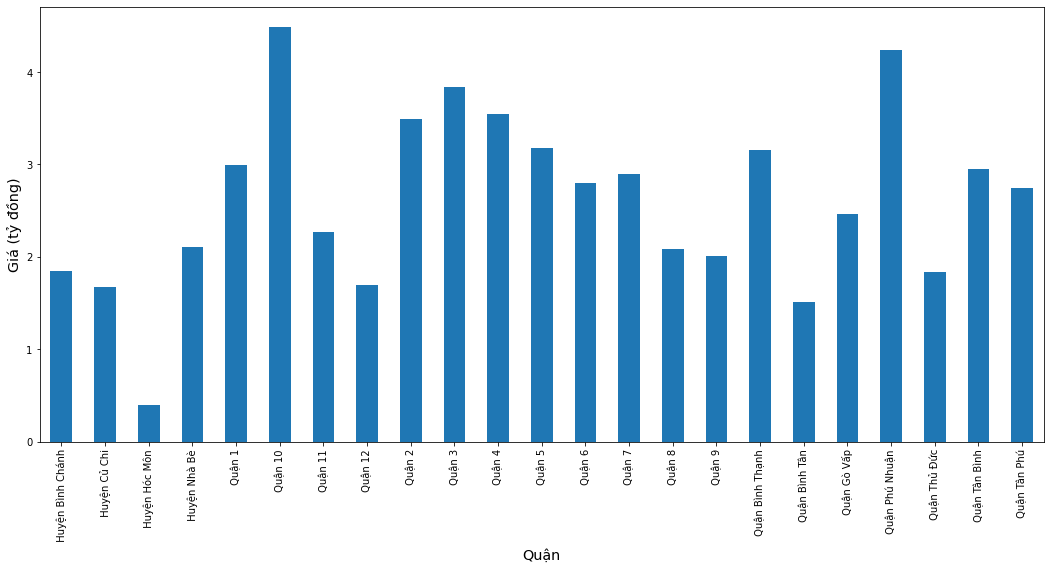

In [123]:
df.DienTich = pd.to_numeric(df.DienTich)
df.Phongngu = pd.to_numeric(df.Phongngu)
df.PhongTam = pd.to_numeric(df.PhongTam)
df.Gia = pd.to_numeric(df.Gia)
df.dtypes
df_temp = df.copy()
df_temp = df_temp.groupby("Quan")["Gia"].mean() / 1_000_000_000
plt.rcParams['figure.figsize'] = (18, 8)
plt.ylabel("Giá (tỷ đồng)", fontsize="x-large")
df_temp.plot.bar()
plt.xlabel("Quận", fontsize="x-large")
plt.show()

## 2. Nội thất

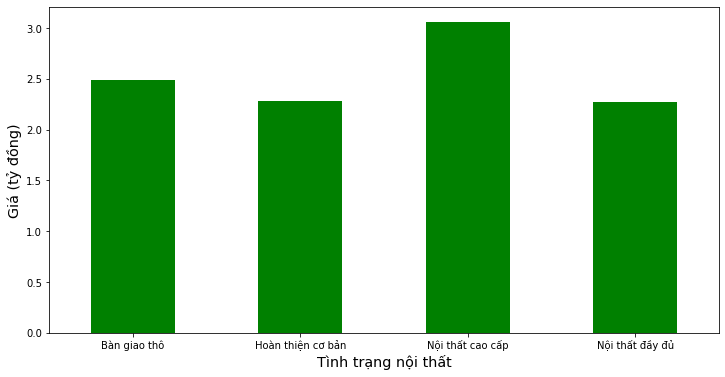

In [130]:
df_temp = df.copy()
df_temp = df_temp.groupby("TinhTrangNoiThat")["Gia"].mean() / 1_000_000_000
plt.rcParams['figure.figsize'] = (12, 6)
plt.ylabel("Giá (tỷ đồng)", fontsize="x-large")
df_temp.plot.bar(color="green")
plt.xlabel("Tình trạng nội thất", fontsize="x-large")
plt.xticks(rotation=0)
plt.show()

## 3. Loại hình 

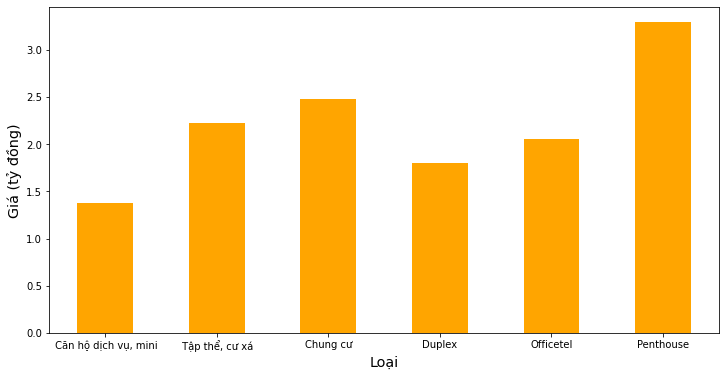

In [129]:
df_temp = df.copy()
df_temp = df_temp.groupby("Loai")["Gia"].mean() / 1_000_000_000
plt.rcParams['figure.figsize'] = (12, 6)
plt.ylabel("Giá (tỷ đồng)", fontsize="x-large")
df_temp.plot.bar(color="orange")
plt.xlabel("Loại", fontsize="x-large")
plt.xticks(rotation=0)
plt.show()